# Tabular Data Case Study: Analyzing sleep data using the National Health and Nutrition Examination Survey dataset

Sleep Questionaire Data in the file `P_SLQ.xpt` were downloaded from the CDC 2017-2020 pre-pandemic [National Health and Nutrition Examination Survey] (https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&Cycle=2017-2020).

**We probably won't be able to ask too many interesting questions from this file alone. Instead, we'll plant to merge this sleep data with other questions from respondents (e.g. access to shelter, work hours, anxiety, depression, substance user, etc) that can test hypotheses about what influences sleep.**

So once we've completed this analysis on this table, we'll need to repeat on additional table(s) of your choice to link up those data based on the respondent id number.

This file is in SAS transport format (`.xpt`) which can be read by pandas. Column names are not informative or readable directly, but instead reflect codes matching to different questions in the survey. 

## Check that the `P_SLQ`.xpt data file is in our current directory
We'll start by double-checking that the file is in our current working directory.

In [46]:
from os import listdir
listdir()

['nhanes_sleep_data.ipynb', '.ipynb_checkpoints', 'P_SLQ.xpt']

## Load the NHANES data into a dataframe using the pandas `read_sas` function

SAS is a popular statistical program. In python, pandas can read several sas formats including the `.xpt` transport format and load them as `DataFrame` objects. This is useful for loading government data stored in this format.

In [47]:
import pandas as pd
sleep_data = pd.read_sas('P_SLQ.xpt')
sleep_data

,SEQN,SLQ300,SLQ310,SLD012,SLQ320,SLQ330,SLD013,SLQ030,SLQ040,SLQ050,SLQ120
0,109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
1,109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
2,109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
3,109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
4,109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
10190,124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
10191,124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
10192,124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00
10193,124821.0,b'21:00',b'04:45',8.0,b'00:00',b'09:00',9.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00


If you scroll to the bottom of the DataFrame output, you should see `10195 rows x 11 columns`. That means we have 10,195 people who responded to the NHANES survey and 11 Questions they answered (after quality control done by the surveyers). 

Some of these records will be incomplete due to people refusing to answer or not knowing the answer to certain questions, and will have to be filtered out later. We can check the number of rows and columns after each filtering step to confirm whether we have removed rows.

## List all columns of the NHANES sleep data


In [48]:
column_names = sleep_data.columns
#Column names initially come as a pandas Index object, 
#so let's convert them to a plain list.
column_names = list(column_names)
print(column_names)

['SEQN', 'SLQ300', 'SLQ310', 'SLD012', 'SLQ320', 'SLQ330', 'SLD013', 'SLQ030', 'SLQ040', 'SLQ050', 'SLQ120']


Great! Now we have some column names to work with. We'll need to read the study and its documentation to be able to understand what these mean and carefully interpret them.

## Read background on the study and column names

The file has an accompanying documentation file (accessible from the linked page at top, to the left of the link for the XPT file for sleep). The direct link for the documentation file is here:

https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SLQ.htm

It is critical to read the document in full to understand methods. Once that's done, we can create a dictionary to map the nhanes code names to more readable shorthand column names. Note that some columns have special numeric values ('7777' = refused to say). We should either filter these out or replace them with strings so they don't confound statistical analysis or averages.

It looks like the `SEQN` column is critical, because it contains a unique id for each of the >10,000 people responding to the survey that can link responses across multiple questions, letting us connect someones sleep patterns to other socioeconomic, psychological or biological factors using other NHANES datasets.

## Create a dictionary mapping NHANES values to more readable names
This part is kind of tedious. We have to go to the table of variable meanings in the documentation above, read each code, and write a dictionary entry mapping up that code to a consistently formatted column name. I opted to use underscores rather than spaces, keep all column names lowercase, and shorthand some very long descriptions (e.g. usual sleep time on weekdays or workdays --> `usual_sleep_time_on_weekdays`, "how often do you snore?" -> `snoring_frequency`).

We know there are only 11 columns though, so its easier to dot his by hand than in an automated way. If tehere were dozens of columns or more, it might be worth copying and pasting the text descriptions (or the HTML holding them, and writing python code to create this dictionary in an automated way by parsing the text (or HTML).

For now we'll just do it by hand.

In [49]:
#Define the giant dictionary. We'll use \ line continuation characters to keep things organized with one entry per
#line. Note you can't have anything but a newline (enter) after \.

col_name_mapping = \
  {"SEQN":"respondent_sequence_number",\
   "SLQ300":"usual_sleep_time_on_weekdays",\
   "SLQ310":"usual_wake_time_on_weekdays",\
   "SLQ320":"usual_sleep_time_on_weekends",\
   "SLQ330":"usual_wake_time_on_weekends",\
   "SLD012":"sleep_hours_on_weekdays",\
   "SLD013":"sleep_hours_on_weekends",\
   "SLQ030":"snoring_frequency",\
   "SLQ040":"snorting_or_stop_breathing_frequency",
   "SLQ050":"told_doctor_trouble_sleeping",\
   "SLQ120":"overly_sleepy_in_day_frequency"} 

## Use our column mapping to rename the columns in our dataframe

We can use a for loop to replace the columns of the dataframe with our updated, more informative names.


In [50]:
new_col_names = []
for c in column_names:
    #Index into our dictionary, look up the code
    #and get back the new column name
    #then assign it to new name
    new_name = col_name_mapping[c]
    new_col_names.append(new_name)

print(new_col_names)

['respondent_sequence_number', 'usual_sleep_time_on_weekdays', 'usual_wake_time_on_weekdays', 'sleep_hours_on_weekdays', 'usual_sleep_time_on_weekends', 'usual_wake_time_on_weekends', 'sleep_hours_on_weekends', 'snoring_frequency', 'snorting_or_stop_breathing_frequency', 'told_doctor_trouble_sleeping', 'overly_sleepy_in_day_frequency']


Another way to get the new column names is to use a *list comprehension* — a shorthand way of generating a list using a for loop. List comprehensions are similar to the full code above, but shorter to write. Here's how that would look:

In [51]:
new_col_names = [col_name_mapping[c] for c in column_names]
print(new_col_names)

['respondent_sequence_number', 'usual_sleep_time_on_weekdays', 'usual_wake_time_on_weekdays', 'sleep_hours_on_weekdays', 'usual_sleep_time_on_weekends', 'usual_wake_time_on_weekends', 'sleep_hours_on_weekends', 'snoring_frequency', 'snorting_or_stop_breathing_frequency', 'told_doctor_trouble_sleeping', 'overly_sleepy_in_day_frequency']


## Set the columns of our dataframe based on the new names

In [52]:
sleep_data.columns = new_col_names
sleep_data

,respondent_sequence_number,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
0,109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
1,109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
2,109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
3,109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
4,109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
10190,124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
10191,124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
10192,124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00
10193,124821.0,b'21:00',b'04:45',8.0,b'00:00',b'09:00',9.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00


## Set the respondent id as the index row

The respondent id provides a unique id for each row. We should use it rather than the arbitrary numbers on hte left edge of our dataframe that pandas has added. This will simplify linking up data from the sampe people across different parts of the survey.

In [53]:
sleep_data = sleep_data.set_index("respondent_sequence_number")
sleep_data

,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
respondent_sequence_number,,,,,,,,,,
109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...
124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00


## Clean up data by replacing special values

This part has to be done for each column you want to use, somewhat by hand. This is because the surveyers used numeric codes to represent text entries. Not my favorite practice!

Sleep hours on weekends have one special code, `.` to indicate missing data.

In [54]:
sleep_data[sleep_data["sleep_hours_on_weekends"] == "."]["sleep_hours_on_weekends"] = "missing"
sleep_data

,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
respondent_sequence_number,,,,,,,,,,
109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...
124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00


**At this point you should look back at the codebook for your variables of interest. Do they use special codes? If so which ones? Do you need to remove those rows?**

## Manually check for what kinds of special values are in a data column

If we want our results to be accurate, there's no substitute for actually looking at the data to double check if there are missing, "weird" or specially-coded entries that could mess with averages, graphs, or statistics. To do so, we can just grab the columns we want to use, convert them to standard python lists and check them for weird values by hand.

In [55]:
wake_times = sleep_data["usual_wake_time_on_weekends"]
wake_times = list(wake_times)
print(wake_times)

[b'07:00', b'11:00', b'07:00', b'12:00', b'05:00', b'07:00', b'08:00', b'07:00', b'11:00', b'08:00', b'10:00', b'09:00', b'15:00', b'12:00', b'01:30', b'05:30', b'05:00', b'08:00', b'08:00', b'', b'11:00', b'08:00', b'10:00', b'07:30', b'06:30', b'07:00', b'06:00', b'09:00', b'07:30', b'10:00', b'06:00', b'05:00', b'08:00', b'09:30', b'06:30', b'07:00', b'06:00', b'08:00', b'11:00', b'07:00', b'06:00', b'07:00', b'06:00', b'06:00', b'11:00', b'07:00', b'06:30', b'08:00', b'07:30', b'06:00', b'07:00', b'07:00', b'05:00', b'10:00', b'09:30', b'13:00', b'10:00', b'08:00', b'05:00', b'08:00', b'08:30', b'08:00', b'09:00', b'08:00', b'07:00', b'06:30', b'07:00', b'14:00', b'06:30', b'07:30', b'07:00', b'08:00', b'08:00', b'11:00', b'02:30', b'09:00', b'09:00', b'09:00', b'07:30', b'08:30', b'08:00', b'10:00', b'07:30', b'10:00', b'12:00', b'08:00', b'08:00', b'12:00', b'08:00', b'07:00', b'10:00', b'05:00', b'08:00', b'06:00', b'08:00', b'10:00', b'07:00', b'07:00', b'07:00', b'06:30', b'07

That's a lot of data to look through! We can simplify a little bit by converting our list to a Set object, which keeps only unique values (but loses track of order), then back to a list again.

In [56]:
unique_wake_times = set(wake_times)
unique_wake_times = list(unique_wake_times)
print(unique_wake_times)

[b'', b'08:00', b'14:00', b'13:00', b'06:45', b'01:00', b'04:15', b'01:10', b'20:00', b'23:00', b'02:00', b'02:45', b'05:45', b'07:15', b'07:40', b'09:45', b'12:30', b'00:00', b'03:50', b'04:45', b'20:30', b'17:00', b'05:20', b'06:30', b'99999', b'16:30', b'06:10', b'10:00', b'09:00', b'08:45', b'09:15', b'14:30', b'06:15', b'07:30', b'03:00', b'00:30', b'06:00', b'04:30', b'04:05', b'11:30', b'06:20', b'19:00', b'05:40', b'10:45', b'03:05', b'13:30', b'14:50', b'04:00', b'07:00', b'07:45', b'16:00', b'11:00', b'05:35', b'77777', b'10:30', b'06:50', b'05:15', b'01:30', b'05:50', b'08:15', b'12:00', b'05:00', b'15:00', b'15:30', b'09:30', b'02:30', b'03:30', b'18:00', b'07:10', b'08:05', b'05:30', b'17:30', b'04:20', b'08:30', b'21:00', b'18:30']


The entry marked b'' is missing data, rather than a time. We probably want to filter out these responses if wake time is important for our analysis.

In [57]:
bad_rows = sleep_data["usual_wake_time_on_weekends"] == b''
#Select just rows that aren't bad. ! means not so !bad rows grabs all rows not in the bad_rows list
sleep_data = sleep_data[~bad_rows]
sleep_data

,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
respondent_sequence_number,,,,,,,,,,
109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...
124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00


## Remove rows with non-data responses

To remove *all* responses from people who had missing data for our row of interest, we can use row selection in pandas.

NOTE: this will only remove data that shows up as nan (not a number) in pandas. For columns where they used large numbers to indicate certain things, we have to either directly filter out rows that have that number, or replace it with another name and then filter them out.

In [29]:
sleep_data = sleep_data.dropna()
sleep_data

,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
respondent_sequence_number,,,,,,,,,,
109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...
124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00


## Filter out all rows that have non-numeric data


In [61]:
sleep_data = sleep_data.dropna()
sleep_data

,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
respondent_sequence_number,,,,,,,,,,
109266.0,b'22:00',b'05:30',7.5,b'23:00',b'07:00',8.0,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109267.0,b'00:00',b'08:00',8.0,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109268.0,b'22:00',b'06:30',8.5,b'23:00',b'07:00',8.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
109271.0,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109273.0,b'08:00',b'14:35',6.5,b'21:00',b'05:00',8.0,5.397605e-79,5.397605e-79,1.0,2.000000e+00
...,...,...,...,...,...,...,...,...,...,...
124815.0,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00


## Example analysis: plot a boxplot of reported sleep on weekdays vs. weekends

Let's plot a boxplot comparing sleep hours on weekdays vs. weekends and test for significant differences using a t-test. We can do this using example code from the "A Quick Win in Python" chapter.


Text(0.5, 0, 'Schedule')

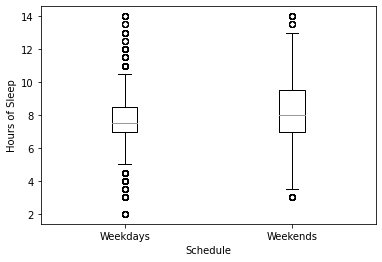

In [68]:
import matplotlib.pyplot as plt

sleep_weekdays = list(sleep_data["sleep_hours_on_weekdays"])

sleep_weekends = list(sleep_data["sleep_hours_on_weekends"])

#Put these two lists together into a list of lists so we have two columns of data
data = [sleep_weekdays,sleep_weekends]

#Make a list of strings to represent the labels for each column
treatments = ["Weekdays","Weekends"]

#Draw the boxplot
plt.boxplot(data,labels=treatments)

#Label the y-axis
plt.ylabel("Hours of Sleep")

#Label the x-axis
plt.xlabel("Schedule")

### Check significance with a T-test

In [86]:
from scipy.stats import ttest_ind
ttest_ind(sleep_weekdays,sleep_weekends)

Ttest_indResult(statistic=-29.480963160103602, pvalue=4.964789149988736e-187)

p << 0.05, indicating that the higher median sleep on weekends is statistically significant.

However, note that the sampled population may not be representative of national demographics, so if we were really using this in a publication then in addition to building more sophisticated statistical models to account for multiple variables, we should also weight responses by demographics. Those demographic weights are provided by NHANES for each survey period.

## Link Sleep Data to Cardiovascular health data

Now let's get another data file to compare responses across. For example, we might want to compare hours of sleep to risk for cardiovascular events. 

Let's download the Cardiovascular Health `P_CDQ.xpt` file. Be sure to put it in the same directory as the sleep data.

### Check we've got the file in our current working directory

In [69]:
listdir()

['nhanes_sleep_data.ipynb', '.ipynb_checkpoints', 'P_SLQ.xpt', 'P_CDQ.xpt']

### Load the cardiovascular data

As this is another SAS `.xpt` transport file, we'll again use the `read_sas` function.

In [76]:
cardio_data = pd.read_sas("P_CDQ.xpt")
cardio_data

,SEQN,CDQ001,CDQ002,CDQ003,CDQ004,CDQ005,CDQ006,CDQ009A,CDQ009B,CDQ009C,CDQ009D,CDQ009E,CDQ009F,CDQ009G,CDQ009H,CDQ008,CDQ010
0,109271.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0
1,109274.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,109282.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0
3,109283.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,109284.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,124815.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
6429,124817.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
6430,124818.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0
6431,124821.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


## Set the patient id as the index

In [77]:
cardio_data = cardio_data.set_index("SEQN")

### Replace each column code with a more informative name

At this step, you can create your own dictionary that maps each column code to a more informative name, using the documentation for the dataset in the 'Documentation' column, or using this [link](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_CDQ.htm).

### Merge the two tables

In [80]:
merged_data = cardio_data.merge(sleep_data,how="inner",left_index=True,right_index=True)
merged_data

,CDQ001,CDQ002,CDQ003,CDQ004,CDQ005,CDQ006,CDQ009A,CDQ009B,CDQ009C,CDQ009D,...,usual_sleep_time_on_weekdays,usual_wake_time_on_weekdays,sleep_hours_on_weekdays,usual_sleep_time_on_weekends,usual_wake_time_on_weekends,sleep_hours_on_weekends,snoring_frequency,snorting_or_stop_breathing_frequency,told_doctor_trouble_sleeping,overly_sleepy_in_day_frequency
109271.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'23:00',b'09:00',10.0,b'23:00',b'12:00',13.0,5.397605e-79,5.397605e-79,1.0,3.000000e+00
109274.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'21:30',b'07:00',9.5,b'21:30',b'07:00',9.5,1.000000e+00,5.397605e-79,2.0,5.397605e-79
109282.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'23:00',b'06:00',7.0,b'23:00',b'07:00',8.0,3.000000e+00,5.397605e-79,1.0,3.000000e+00
109283.0,1.0,1.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,...,b'01:00',b'10:30',9.5,b'03:00',b'11:00',8.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00
109284.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'22:00',b'06:00',8.0,b'22:00',b'08:00',10.0,5.397605e-79,5.397605e-79,2.0,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124815.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'03:00',b'09:00',6.0,b'03:00',b'09:00',6.0,5.397605e-79,5.397605e-79,2.0,1.000000e+00
124817.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'01:00',b'09:00',8.0,b'01:00',b'09:00',8.0,3.000000e+00,5.397605e-79,2.0,1.000000e+00
124818.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'01:00',b'07:00',6.0,b'01:00',b'08:00',7.0,3.000000e+00,5.397605e-79,2.0,2.000000e+00
124821.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b'21:00',b'04:45',8.0,b'00:00',b'09:00',9.0,5.397605e-79,5.397605e-79,2.0,2.000000e+00


## Example analysis: plot  hours of sleep on weekdays for people with or without of chest pain.

Text(0.5, 0, 'Schedule')

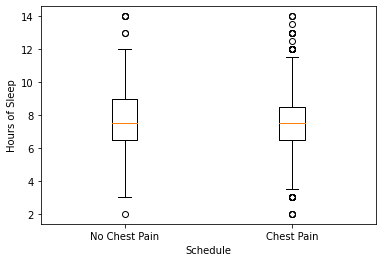

In [85]:
chest_pain = list(merged_data['CDQ008'])

sleep_no_chest_pain = merged_data[merged_data['CDQ008'] == 1.0]["sleep_hours_on_weekdays"]
sleep_chest_pain = merged_data[merged_data['CDQ008'] == 2.0]["sleep_hours_on_weekdays"]

data = [sleep_no_chest_pain,sleep_chest_pain]
#Make a list of strings to represent the labels for each column
treatments = ["No Chest Pain","Chest Pain"]

#Draw the boxplot
plt.boxplot(data,labels=treatments)

#Label the y-axis
plt.ylabel("Hours of Sleep")

#Label the x-axis
plt.xlabel("Schedule")


### Use a T-test to compare results

Here we're comparing the amount of weekday sleep in respondents who said they had severe chest pain

In [87]:
from scipy.stats import ttest_ind
ttest_ind(sleep_no_chest_pain,sleep_chest_pain)

Ttest_indResult(statistic=0.9017620008207323, pvalue=0.36730217041854685)